## FAST UNIVARIATE TIME-SERIES CLASSIFICATION

This notebook explores the classification of univariate time-series data by three methods:
- Via Tabularization + RandomForest
- Via Feature Extraction + RandomForest
- Direct univariate + ROCKET

In [ ]:
import pandas as pd

d = {'A': [[1,2,3,4,5,6,7],[8,9,10,11,12,13,14],[15,16,17,18,19,20,21]]}
df = pd.DataFrame(d)
df

,A
0,"[1, 2, 3, 4, 5, 6, 7]"
1,"[8, 9, 10, 11, 12, 13, 14]"
2,"[15, 16, 17, 18, 19, 20, 21]"


In [ ]:
d_alt = {'A': ["[1,2,3,4,5,6,7]","[8,9,10,11,12,13,14]","[15,16,17,18,19,20,21]"]}
df_alt = pd.DataFrame(d_alt)
df_alt

,A
0,"[1,2,3,4,5,6,7]"
1,"[8,9,10,11,12,13,14]"
2,"[15,16,17,18,19,20,21]"


In [ ]:
not 'B' in d_alt

True

In [ ]:
type(df_alt['A'][0])

str

In [ ]:
df_alt['A'] = [ini_list.strip('][').split(',') for ini_list in df_alt['A']]
df_alt

,A
0,"[1, 2, 3, 4, 5, 6, 7]"
1,"[8, 9, 10, 11, 12, 13, 14]"
2,"[15, 16, 17, 18, 19, 20, 21]"


In [ ]:
type(df_alt['A'][0])

list

In [ ]:
def explode_transposed(df):
  df = df.transpose()
  values = [tup[0] for tup in zip(df.values[0])]
  return [[v[i] for v in values] for i in range(len(values[0]))]

pd.DataFrame(explode_transposed(df))

,0,1,2
0,1,8,15
1,2,9,16
2,3,10,17
3,4,11,18
4,5,12,19
5,6,13,20
6,7,14,21


### Dependencies and Methods

In [ ]:
!pip install sktime --quiet
!pip install sktime[all_extras] --quiet
!pip install matplotlib==3.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.4/661.4 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from warnings import simplefilter
from pandas.core.common import random_state
import matplotlib.pyplot as plt

from sktime.transformations.panel.rocket import MiniRocket, MiniRocketMultivariate
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.datatypes._panel._convert import from_nested_to_2d_array

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier  # get a baseline for comparison

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


In [ ]:
def str2listf(l):
    l = l.replace("[", "")
    l = l.replace("]", "")
    l = l.replace("\n", "")
    l = l.split(', ')
    l = [float(i) for i in l]
    return l


def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True User')
  plt.xlabel('Predicted User')

### Data and Pre-processing

In [ ]:
df = pd.read_csv('arup_ml_ready_binary_norm_extremes_nooutliers_MAD.csv')  # arup_normal_binary, arup_ml_ready_extremes.csv
print("size: ", df.size)
df

size:  528


,Unnamed: 0,pupil_dilation,relative_pupil_dilation,rating
0,4,"[-0.3565, -0.3565, -0.3464, -0.3592, -0.4445, ...","[-0.3153, -0.3153, -0.3046, -0.3167, -0.3976, ...",4.0
1,6,"[-0.3151, 0.3373, 0.7393, 0.8382, 0.89, 0.9478...","[-0.3152, 0.3373, 0.7393, 0.8382, 0.89, 0.9478...",1.0
2,10,"[0.0674, 0.0674, -0.0219, -0.0304, -0.059, -0....","[0.1563, 0.1563, 0.0782, 0.0562, 0.0342, 0.031...",1.0
3,13,"[-0.0811, -0.0811, -0.2045, -0.2982, -0.3385, ...","[-0.0811, -0.0811, -0.2045, -0.2982, -0.3386, ...",1.0
4,18,"[0.6868, 0.682, 0.626, 0.6812, 0.7274, 0.6455,...","[0.6868, 0.6819, 0.626, 0.6811, 0.7273, 0.6454...",1.0
...,...,...,...,...
127,462,"[-2.3485, -2.3439, -2.2964, -2.2552, -2.2342, ...","[-2.4216, -2.4167, -2.3715, -2.3282, -2.3036, ...",1.0
128,465,"[-2.0049, -1.9824, -2.0558, -2.0108, -2.0558, ...","[-2.0307, -2.0087, -2.0796, -2.0392, -2.0796, ...",4.0
129,466,"[-0.2462, -0.3986, -0.0733, -0.1234, -0.1507, ...","[-0.2282, -0.3823, -0.0579, -0.1022, -0.1302, ...",4.0
130,468,"[-1.4679, -1.5208, -1.43, -1.5587, -1.727, -1....","[-1.4674, -1.5204, -1.4296, -1.5582, -1.7266, ...",1.0


In [ ]:
df.rating.value_counts()

4.0    68
1.0    58
0.0     6
Name: rating, dtype: int64

In [ ]:
df.rating = df.rating.map(lambda i: 1 if i>3 else 0)
df.rating.value_counts()

1    68
0    64
Name: rating, dtype: int64

In [ ]:
# GLOBAL PRE-PROCESSING

df.index = df['Unnamed: 0'].tolist()
del df['Unnamed: 0']

df.pupil_dilation = df.pupil_dilation.apply(str2listf)
# df.baseline = df.baseline.apply(str2listf)
df.relative_pupil_dilation = df.relative_pupil_dilation.apply(str2listf)
df['rating'] = df['rating'].apply(lambda i: int(i))
df

,pupil_dilation,relative_pupil_dilation,rating
4,"[-0.3565, -0.3565, -0.3464, -0.3592, -0.4445, ...","[-0.3153, -0.3153, -0.3046, -0.3167, -0.3976, ...",1
6,"[-0.3151, 0.3373, 0.7393, 0.8382, 0.89, 0.9478...","[-0.3152, 0.3373, 0.7393, 0.8382, 0.89, 0.9478...",0
10,"[0.0674, 0.0674, -0.0219, -0.0304, -0.059, -0....","[0.1563, 0.1563, 0.0782, 0.0562, 0.0342, 0.031...",0
13,"[-0.0811, -0.0811, -0.2045, -0.2982, -0.3385, ...","[-0.0811, -0.0811, -0.2045, -0.2982, -0.3386, ...",0
18,"[0.6868, 0.682, 0.626, 0.6812, 0.7274, 0.6455,...","[0.6868, 0.6819, 0.626, 0.6811, 0.7273, 0.6454...",0
...,...,...,...
462,"[-2.3485, -2.3439, -2.2964, -2.2552, -2.2342, ...","[-2.4216, -2.4167, -2.3715, -2.3282, -2.3036, ...",0
465,"[-2.0049, -1.9824, -2.0558, -2.0108, -2.0558, ...","[-2.0307, -2.0087, -2.0796, -2.0392, -2.0796, ...",1
466,"[-0.2462, -0.3986, -0.0733, -0.1234, -0.1507, ...","[-0.2282, -0.3823, -0.0579, -0.1022, -0.1302, ...",1
468,"[-1.4679, -1.5208, -1.43, -1.5587, -1.727, -1....","[-1.4674, -1.5204, -1.4296, -1.5582, -1.7266, ...",0


In [ ]:
df.rating.value_counts()

1    68
0    64
Name: rating, dtype: int64

In [ ]:
# Univariate 1 (join baseline to pupil_dilation)
# binary rule : # df_alt['rating'] = df['rating'].apply(lambda i: 0 if i<3 else 1)

# df_alt = df.copy(deep=True)

# df_alt.rating = df_alt.rating.astype(str)
# df_alt['pupil_dilation'] = [b + p for b, p in zip(df_alt['baseline'], df_alt['pupil_dilation'])]
# del df_alt['baseline']
# df_alt

In [ ]:
# Univariate 2
df_alt = df.copy(deep=True)
df_alt.rating = df_alt.rating.astype(str)
# del df_alt['baseline']
df_alt

,pupil_dilation,relative_pupil_dilation,rating
4,"[-0.3565, -0.3565, -0.3464, -0.3592, -0.4445, ...","[-0.3153, -0.3153, -0.3046, -0.3167, -0.3976, ...",1
6,"[-0.3151, 0.3373, 0.7393, 0.8382, 0.89, 0.9478...","[-0.3152, 0.3373, 0.7393, 0.8382, 0.89, 0.9478...",0
10,"[0.0674, 0.0674, -0.0219, -0.0304, -0.059, -0....","[0.1563, 0.1563, 0.0782, 0.0562, 0.0342, 0.031...",0
13,"[-0.0811, -0.0811, -0.2045, -0.2982, -0.3385, ...","[-0.0811, -0.0811, -0.2045, -0.2982, -0.3386, ...",0
18,"[0.6868, 0.682, 0.626, 0.6812, 0.7274, 0.6455,...","[0.6868, 0.6819, 0.626, 0.6811, 0.7273, 0.6454...",0
...,...,...,...
462,"[-2.3485, -2.3439, -2.2964, -2.2552, -2.2342, ...","[-2.4216, -2.4167, -2.3715, -2.3282, -2.3036, ...",0
465,"[-2.0049, -1.9824, -2.0558, -2.0108, -2.0558, ...","[-2.0307, -2.0087, -2.0796, -2.0392, -2.0796, ...",1
466,"[-0.2462, -0.3986, -0.0733, -0.1234, -0.1507, ...","[-0.2282, -0.3823, -0.0579, -0.1022, -0.1302, ...",1
468,"[-1.4679, -1.5208, -1.43, -1.5587, -1.727, -1....","[-1.4674, -1.5204, -1.4296, -1.5582, -1.7266, ...",0


In [ ]:
X = df.loc[:, ["relative_pupil_dilation"]]  # univariate:  df[['pupil_dilation']] or df[['relative_pupil_dilation']]
y = df_alt[['rating']]
X

,relative_pupil_dilation
4,"[-0.3153, -0.3153, -0.3046, -0.3167, -0.3976, ..."
6,"[-0.3152, 0.3373, 0.7393, 0.8382, 0.89, 0.9478..."
10,"[0.1563, 0.1563, 0.0782, 0.0562, 0.0342, 0.031..."
13,"[-0.0811, -0.0811, -0.2045, -0.2982, -0.3386, ..."
18,"[0.6868, 0.6819, 0.626, 0.6811, 0.7273, 0.6454..."
...,...
462,"[-2.4216, -2.4167, -2.3715, -2.3282, -2.3036, ..."
465,"[-2.0307, -2.0087, -2.0796, -2.0392, -2.0796, ..."
466,"[-0.2282, -0.3823, -0.0579, -0.1022, -0.1302, ..."
468,"[-1.4674, -1.5204, -1.4296, -1.5582, -1.7266, ..."


In [ ]:
y

,rating
4,1
6,0
10,0
13,0
18,0
...,...
462,0
465,1
466,1
468,0


In [ ]:
X = X.applymap(lambda s: pd.Series(s))
print(X.shape, y.shape)
print(X['relative_pupil_dilation'].dtype)
X

(132, 1) (132, 1)
object


,relative_pupil_dilation
4,0 -0.3153 1 -0.3153 2 -0.3046 3 ...
6,0 -0.3152 1 0.3373 2 0.7393 3 ...
10,0 0.1563 1 0.1563 2 0.0782 3 ...
13,0 -0.0811 1 -0.0811 2 -0.2045 3 ...
18,0 0.6868 1 0.6819 2 0.6260 3 ...
...,...
462,0 -2.4216 1 -2.4167 2 -2.3715 3 ...
465,0 -2.0307 1 -2.0087 2 -2.0796 3 ...
466,0 -0.2282 1 -0.3823 2 -0.0579 3 ...
468,0 -1.4674 1 -1.5204 2 -1.4296 3 ...


In [ ]:
df_alt = pd.concat([X, y], axis=1)
df_alt.to_csv("tklearn_ready_uni.csv")

### Classifiers

#### Tabularization

number of samples per class:  64

tuning model...
(data is shuffled)

_____________________________________________________________________

fold:  1
['0' '1'] [51 51]
displaying first {n_display} samples for each class


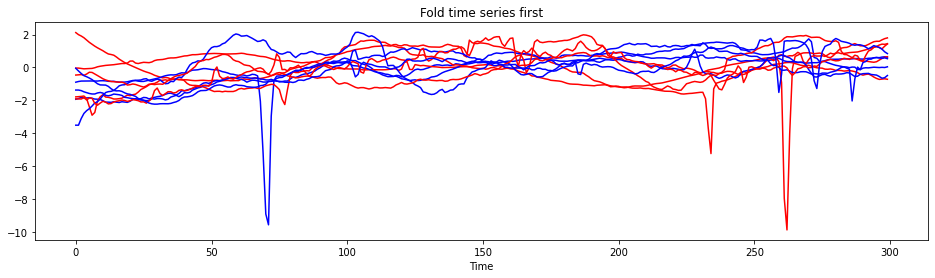

Dummy score:  0.5
random forest score:  0.6538461538461539

0. xtrain (102, 1)
1. ytrain
 (102,)

fold:  2
['0' '1'] [51 51]
displaying first {n_display} samples for each class


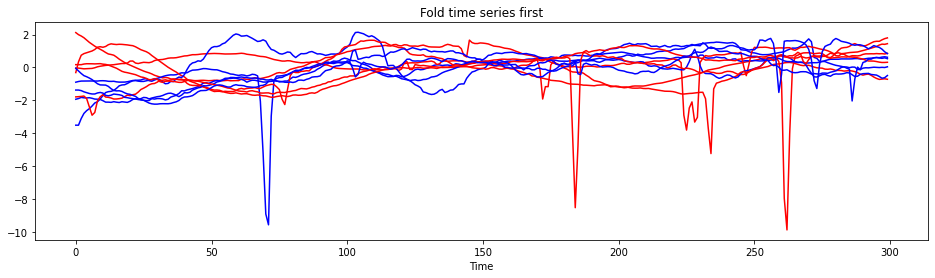

Dummy score:  0.5
random forest score:  0.4230769230769231

0. xtrain (102, 1)
1. ytrain
 (102,)

fold:  3
['0' '1'] [51 51]
displaying first {n_display} samples for each class


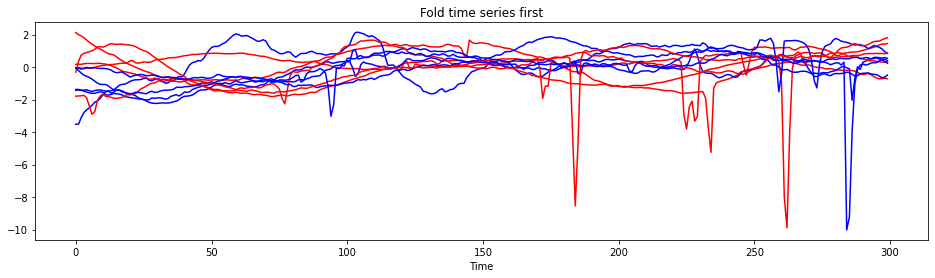

Dummy score:  0.5
random forest score:  0.5384615384615384

0. xtrain (102, 1)
1. ytrain
 (102,)

fold:  4
['0' '1'] [51 52]
displaying first {n_display} samples for each class


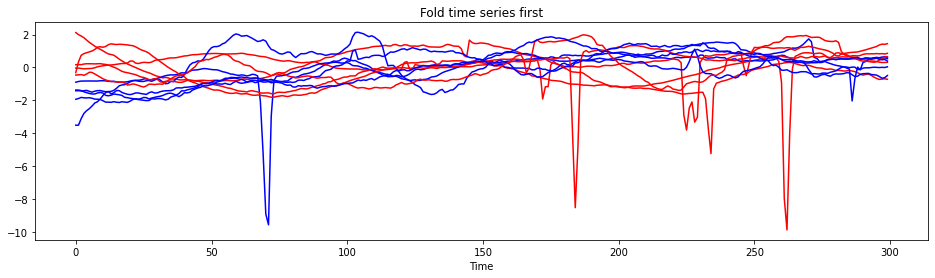

Dummy score:  0.48
random forest score:  0.4

0. xtrain (103, 1)
1. ytrain
 (103,)

fold:  5
['0' '1'] [52 51]
displaying first {n_display} samples for each class


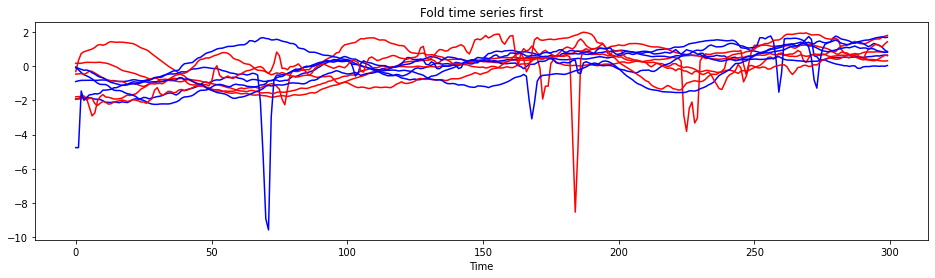

Dummy score:  0.48
random forest score:  0.52

0. xtrain (103, 1)
1. ytrain
 (103,)

best acc:  0.65

_____________________________________________________________________

fold:  1
['0' '1'] [51 51]
displaying first {n_display} samples for each class


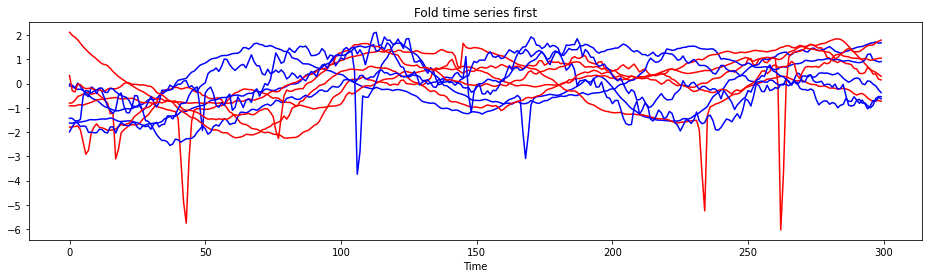

Dummy score:  0.5
random forest score:  0.6153846153846154

0. xtrain (102, 1)
1. ytrain
 (102,)

fold:  2
['0' '1'] [51 51]
displaying first {n_display} samples for each class


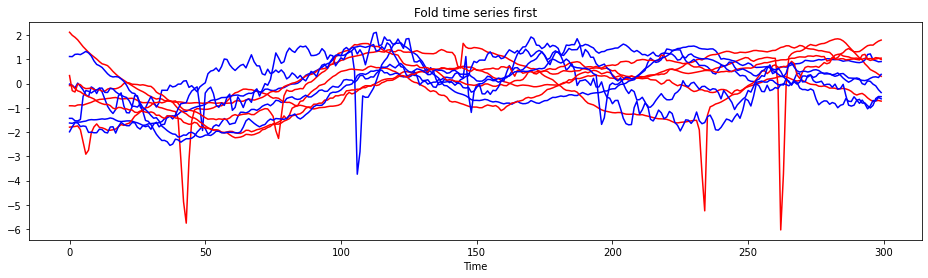

Dummy score:  0.5
random forest score:  0.5769230769230769

0. xtrain (102, 1)
1. ytrain
 (102,)

fold:  3
['0' '1'] [51 51]
displaying first {n_display} samples for each class


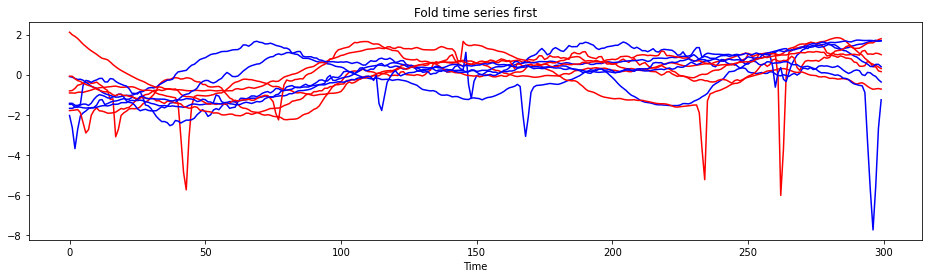

Dummy score:  0.5
random forest score:  0.5

0. xtrain (102, 1)
1. ytrain
 (102,)

fold:  4
['0' '1'] [51 52]
displaying first {n_display} samples for each class


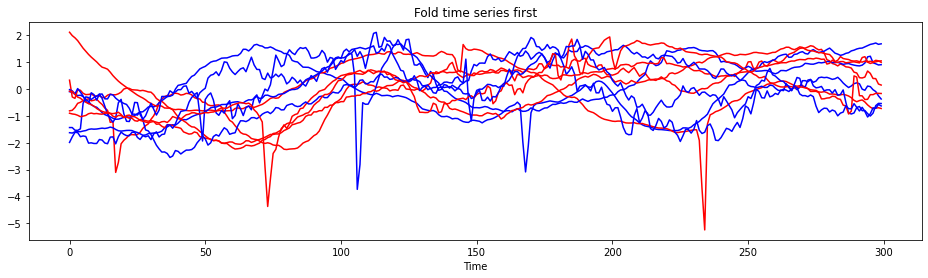

Dummy score:  0.48
random forest score:  0.56

0. xtrain (103, 1)
1. ytrain
 (103,)

fold:  5
['0' '1'] [52 51]
displaying first {n_display} samples for each class


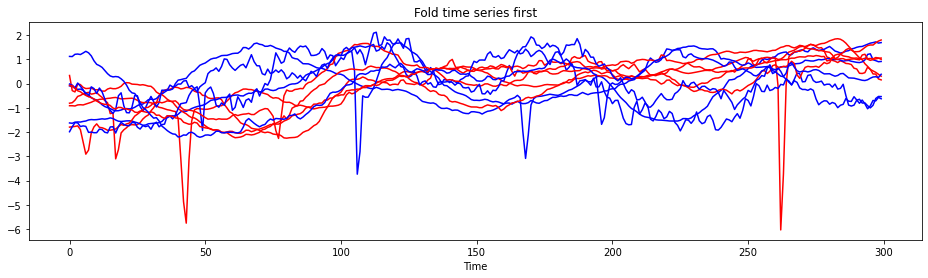

Dummy score:  0.48
random forest score:  0.48

0. xtrain (103, 1)
1. ytrain
 (103,)

best acc:  0.62

_____________________________________________________________________

fold:  1
['0' '1'] [51 51]
displaying first {n_display} samples for each class


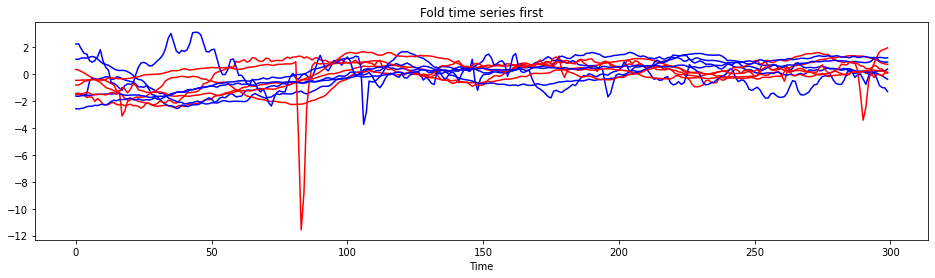

Dummy score:  0.5
random forest score:  0.6153846153846154

0. xtrain (102, 1)
1. ytrain
 (102,)

fold:  2
['0' '1'] [51 51]
displaying first {n_display} samples for each class


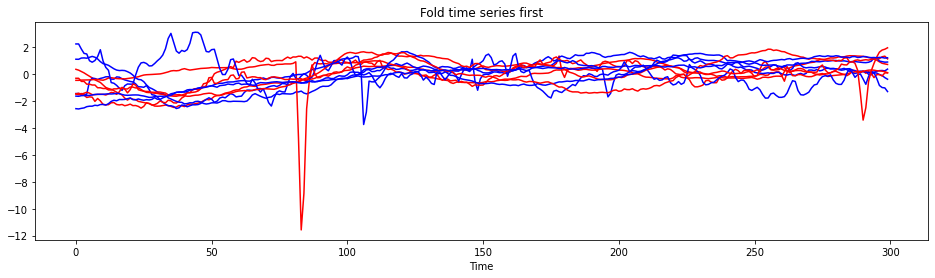

Dummy score:  0.5
random forest score:  0.4230769230769231

0. xtrain (102, 1)
1. ytrain
 (102,)

fold:  3
['0' '1'] [51 51]
displaying first {n_display} samples for each class


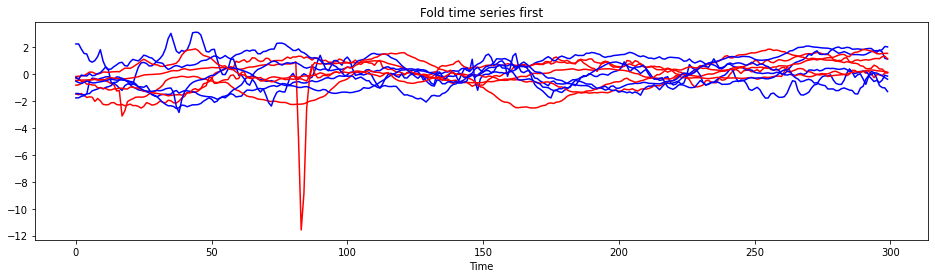

Dummy score:  0.5
random forest score:  0.5

0. xtrain (102, 1)
1. ytrain
 (102,)

fold:  4
['0' '1'] [51 52]
displaying first {n_display} samples for each class


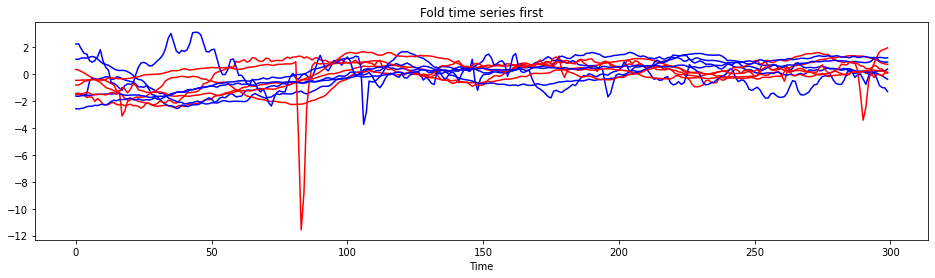

Dummy score:  0.48
random forest score:  0.48

0. xtrain (103, 1)
1. ytrain
 (103,)

fold:  5
['0' '1'] [52 51]
displaying first {n_display} samples for each class


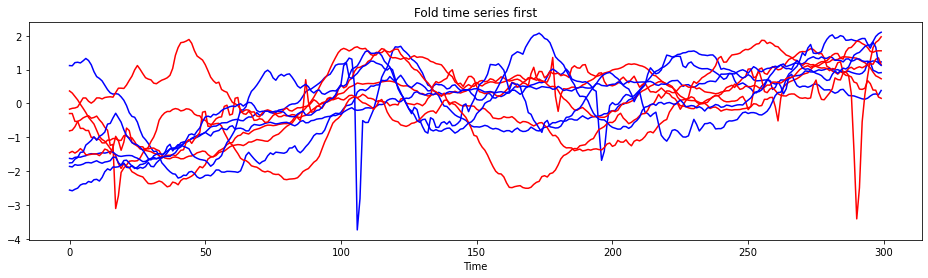

Dummy score:  0.48
random forest score:  0.48

0. xtrain (103, 1)
1. ytrain
 (103,)

best acc:  0.62

_____________________________________________________________________

fold:  1
['0' '1'] [51 51]
displaying first {n_display} samples for each class


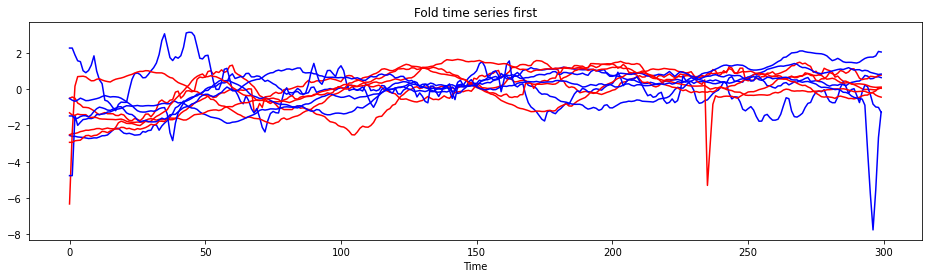

Dummy score:  0.5
random forest score:  0.6153846153846154

0. xtrain (102, 1)
1. ytrain
 (102,)

fold:  2
['0' '1'] [51 51]
displaying first {n_display} samples for each class


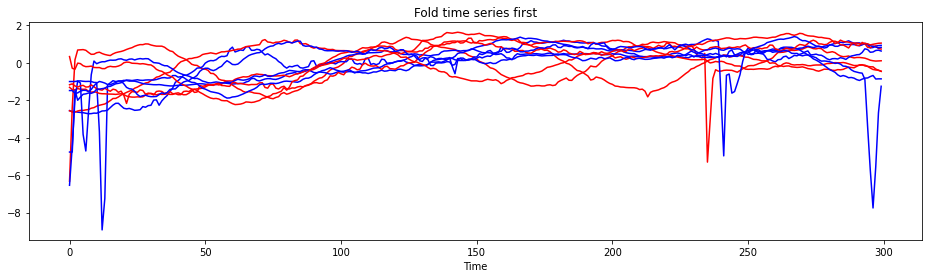

Dummy score:  0.5
random forest score:  0.38461538461538464

0. xtrain (102, 1)
1. ytrain
 (102,)

fold:  3
['0' '1'] [51 51]
displaying first {n_display} samples for each class


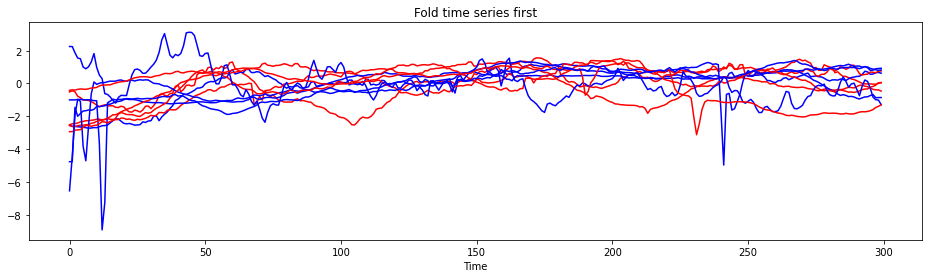

Dummy score:  0.5
random forest score:  0.5

0. xtrain (102, 1)
1. ytrain
 (102,)

fold:  4
['0' '1'] [51 52]
displaying first {n_display} samples for each class


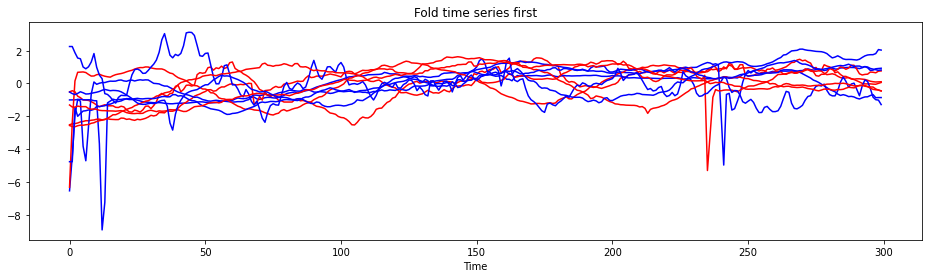

Dummy score:  0.48
random forest score:  0.4

0. xtrain (103, 1)
1. ytrain
 (103,)

fold:  5
['0' '1'] [52 51]
displaying first {n_display} samples for each class


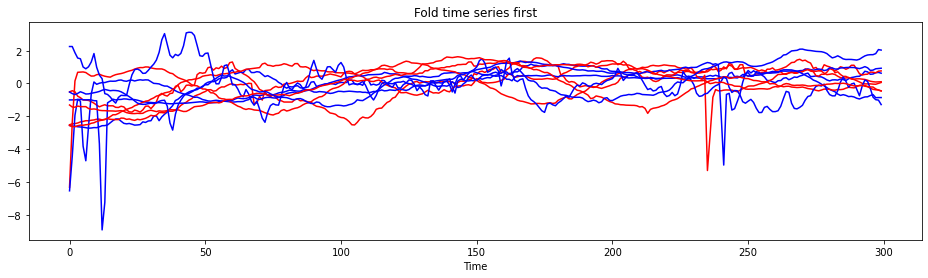

Dummy score:  0.48
random forest score:  0.36

0. xtrain (103, 1)
1. ytrain
 (103,)

best acc:  0.62

_____________________________________________________________________

fold:  1
['0' '1'] [51 51]
displaying first {n_display} samples for each class


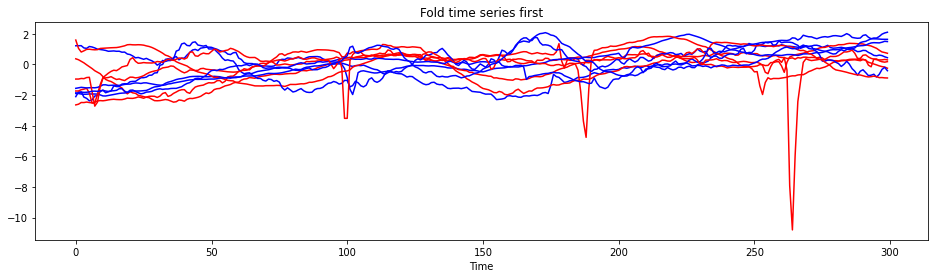

Dummy score:  0.5
random forest score:  0.5769230769230769

0. xtrain (102, 1)
1. ytrain
 (102,)

fold:  2
['0' '1'] [51 51]
displaying first {n_display} samples for each class


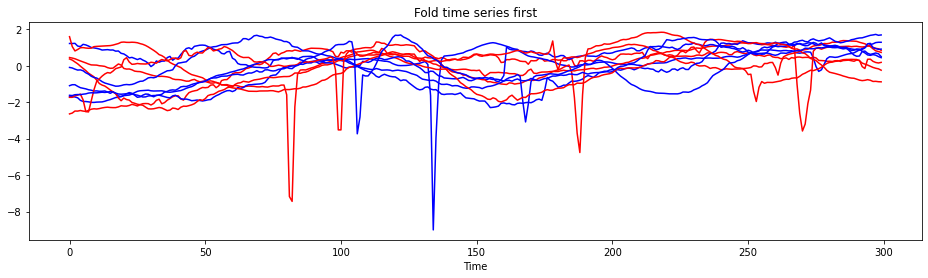

Dummy score:  0.5
random forest score:  0.5769230769230769

0. xtrain (102, 1)
1. ytrain
 (102,)

fold:  3
['0' '1'] [51 51]
displaying first {n_display} samples for each class


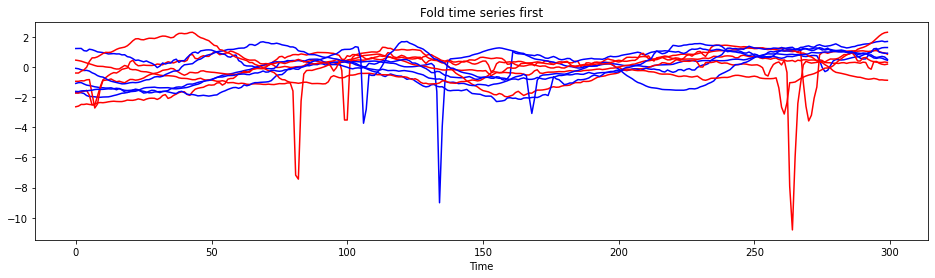

Dummy score:  0.5
random forest score:  0.46153846153846156

0. xtrain (102, 1)
1. ytrain
 (102,)

fold:  4
['0' '1'] [51 52]
displaying first {n_display} samples for each class


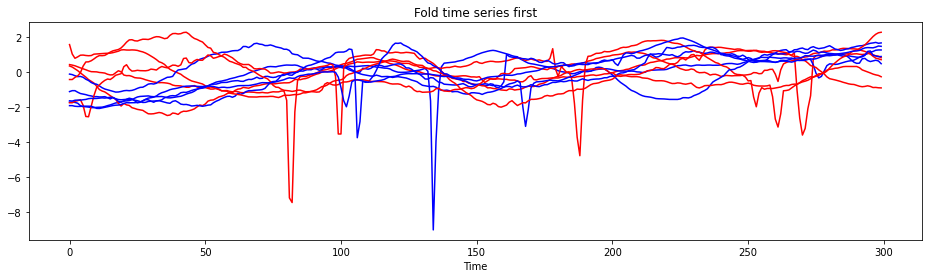

Dummy score:  0.48
random forest score:  0.52

0. xtrain (103, 1)
1. ytrain
 (103,)

fold:  5
['0' '1'] [52 51]
displaying first {n_display} samples for each class


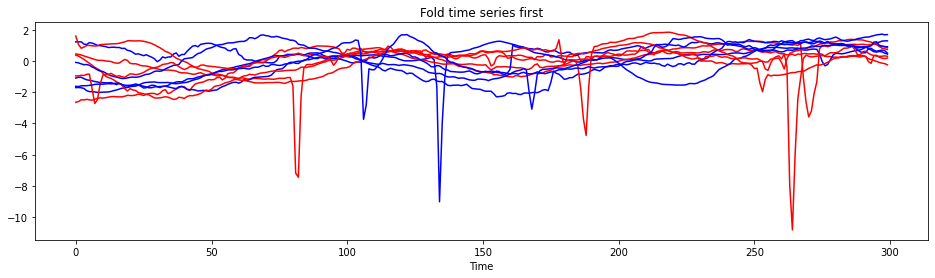

Dummy score:  0.48
random forest score:  0.44

0. xtrain (103, 1)
1. ytrain
 (103,)

best acc:  0.58

best global acc:  0.65
              precision    recall  f1-score   support

           0       0.61      0.85      0.71        13
           1       0.75      0.46      0.57        13

    accuracy                           0.65        26
   macro avg       0.68      0.65      0.64        26
weighted avg       0.68      0.65      0.64        26


TABULARIZATION DATAFRAME SAMPLE: 

     relative_pupil_dilation__0  relative_pupil_dilation__1  \
344                     -2.6442                     -2.5988   
26                       0.4476                      0.4188   
239                      0.3679                      0.3061   
220                      1.5917                      1.0505   
359                     -0.9559                     -0.9559   

     relative_pupil_dilation__2  relative_pupil_dilation__3  \
344                     -2.4874                     -2.4911   
26     

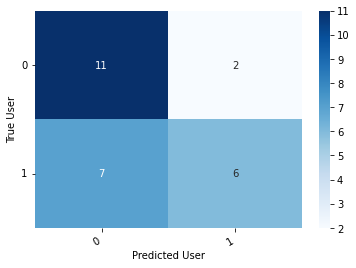

In [ ]:
# 1. ...

import sys
from warnings import simplefilter
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sklearn.ensemble import RandomForestClassifier
from sktime.datatypes._panel._convert import from_nested_to_2d_array
# let's get a baseline for comparison
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score


simplefilter(action='ignore', category=FutureWarning)


seeds = [42, 1, 999, 4276, 67534]
n_samples = min(df_alt.rating.value_counts())

print("number of samples per class: ", n_samples)
print("\ntuning model...")
print("(data is shuffled)")

best_global_acc = 0
best_model = pd.DataFrame()

for seed in seeds:

  df_sample = df_alt.groupby('rating', group_keys=False).apply(lambda x: x.sample(n_samples, random_state=seed))
  # df_sample.participant_name.value_counts()

  y = df_sample['rating']
  X = df_sample
  del X['rating']

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

  print("\n_____________________________________________________________________")

  best_acc = 0
  best_df_eval = pd.DataFrame()

  for ix, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    print("\nfold: ", ix)
    X_train, X_test = X.take(train_index), X.take(test_index)
    y_train, y_test = y.take(train_index), y.take(test_index)

    labels, counts = np.unique(y_train, return_counts=True)
    print(labels, counts)

    n_display = 5
    print("displaying first {n_display} samples for each class")
    fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))

    for i in range(n_display):
      for label in labels:
          X_train.loc[y_train == label, "relative_pupil_dilation"].iloc[i].plot(ax=ax, label=f"class {label}", color='r' if label=="0" else 'b')
    plt.legend()
    ax.set(title="Fold time series first", xlabel="Time");
    ax.get_legend().remove()
    plt.show()

    # X_train = X_train.applymap(lambda s: pd.Series(s))
    # X_test = X_test.applymap(lambda s: pd.Series(s))

    # TABULARIZATION
    X_train_tab = from_nested_to_2d_array(X_train)
    X_test_tab = from_nested_to_2d_array(X_test)

    # print("tabularization: ", X_train_tab.head())

    classifier = DummyClassifier(strategy="prior")
    classifier.fit(X_train_tab, y_train)
    print("Dummy score: ", classifier.score(X_test_tab, y_test))

    # now we can apply any scikit-learn classifier
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(X_train_tab, y_train)
    y_pred = classifier.predict(X_test_tab)
    print("random forest score: ", accuracy_score(y_test, y_pred))

    # display(X_train)
    print("\n0. xtrain", X_train.shape)
    print("1. ytrain\n", y_train.shape)

    # metrics
    predictions = classifier.predict(X_test_tab)

    df_eval = pd.DataFrame([(p, t) for p, t in zip(predictions, y_test.tolist())], columns=["prediction", "truth"])

    if best_acc < classifier.score(X_test_tab, y_test):
      best_acc = classifier.score(X_test_tab, y_test)
      best_df_eval = df_eval

  print("\nbest acc: ", round(best_acc, 2))
  if best_acc > best_global_acc:
    best_global_acc = best_acc
    best_model = best_df_eval

print("\nbest global acc: ", round(best_global_acc, 2))
print(classification_report(best_model.truth.tolist(), best_model.prediction.tolist(), target_names=list(set(best_model.truth.tolist()))))

cm = confusion_matrix(best_model.truth.tolist(), best_model.prediction.tolist())
df_cm = pd.DataFrame(cm, index=list(set(best_model.truth.tolist())), columns=list(set(best_model.truth.tolist())))

print("\nTABULARIZATION DATAFRAME SAMPLE: \n")
print(X_train_tab.head())

show_confusion_matrix(df_cm)
plt.show()

#### Extracting Statistical Features

In [ ]:
# 2. # extract features from the univariate

feature_transformer = TSFreshFeatureExtractor(default_fc_parameters="minimal")
extracted_features = feature_transformer.fit_transform(X)
print(extracted_features.describe())
extracted_features.shape
# extracted_features

df_extrated_features = pd.concat([extracted_features, y], axis=1)
df_extrated_features

Feature Extraction: 100%|██████████| 128/128 [00:00<00:00, 1447.98it/s]

       relative_pupil_dilation__sum_values  relative_pupil_dilation__median  \
count                         1.280000e+02                       128.000000   
mean                         -1.015625e-05                         0.065359   
std                           5.262914e-04                         0.198976   
min                          -1.300000e-03                        -0.388900   
25%                          -4.000000e-04                        -0.100550   
50%                          -1.065814e-14                         0.059300   
75%                           3.000000e-04                         0.218500   
max                           1.600000e-03                         0.577850   

       relative_pupil_dilation__mean  relative_pupil_dilation__length  \
count                   1.280000e+02                            128.0   
mean                   -3.385417e-08                            300.0   
std                     1.754305e-06                              0.0

,relative_pupil_dilation__sum_values,relative_pupil_dilation__median,relative_pupil_dilation__mean,relative_pupil_dilation__length,relative_pupil_dilation__standard_deviation,relative_pupil_dilation__variance,relative_pupil_dilation__root_mean_square,relative_pupil_dilation__maximum,relative_pupil_dilation__absolute_maximum,relative_pupil_dilation__minimum,rating
0,-3.552714e-15,0.19020,-1.184238e-17,300.0,0.999997,0.999995,0.999997,1.2756,4.0418,-4.0418,NaN
1,3.000000e-04,-0.10690,1.000000e-06,300.0,1.000000,1.000000,1.000000,1.5169,4.4675,-4.4675,NaN
2,1.421085e-14,0.29005,4.736952e-17,300.0,1.000001,1.000003,1.000001,1.3782,2.4639,-2.4639,NaN
3,1.000000e-04,-0.06480,3.333333e-07,300.0,1.000000,1.000000,1.000000,1.8348,4.7642,-4.7642,NaN
4,-3.000000e-04,0.19050,-1.000000e-06,300.0,1.000001,1.000002,1.000001,1.4469,3.5218,-3.5218,NaN
...,...,...,...,...,...,...,...,...,...,...,...
462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
# RandomForestClassifier()
# )
# classifier.fit(X_train, y_train)
# classifier.score(X_test, y_test)

# 2. With the extracted features

# todo: X is being replaced everytime so I need run Data and Pre-processing again

import sys
from warnings import simplefilter
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor


simplefilter(action='ignore', category=FutureWarning)


seeds = [42, 1, 999, 4276, 67534]
n_samples = min(df_alt.rating.value_counts())

print("number of samples per class: ", n_samples)
print("\ntuning model...")
print("(data is shuffled)")

best_global_acc = 0
best_model = pd.DataFrame()

for seed in seeds:

  df_sample = df_extrated_features.groupby('rating', group_keys=False).apply(lambda x: x.sample(n_samples, random_state=seed))
  # df_sample.participant_name.value_counts()

  y = df_sample['rating']
  X = df_sample
  del X['rating']


  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

  print("\n_____________________________________________________________________")

  best_acc = 0
  best_df_eval = pd.DataFrame()

  for ix, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    print("\nfold: ", ix)
    X_train, X_test = X.take(train_index), X.take(test_index)
    y_train, y_test = y.take(train_index), y.take(test_index)

    # X_train = X_train.applymap(lambda s: pd.Series(s))
    # X_test = X_test.applymap(lambda s: pd.Series(s))

    # display(X_train)
    print("\n0. xtrain", X_train.shape)
    print("1. ytrain\n", y_train.shape)

    classifier = DummyClassifier(strategy="prior")
    classifier.fit(X_train, y_train)
    print("Dummy score: ", classifier.score(X_test, y_test))

    # now we can apply any scikit-learn classifier
    classifier = RandomForestClassifier(n_estimators=100)

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    print("random forest score: ", accuracy_score(y_test, y_pred))

    # display(X_train)
    print("\n0. xtrain", X_train.shape)
    print("1. ytrain\n", y_train.shape)

    # metrics
    predictions = classifier.predict(X_test)

    df_eval = pd.DataFrame([(p, t) for p, t in zip(predictions, y_test.tolist())], columns=["prediction", "truth"])

    if best_acc < classifier.score(X_test, y_test):
      best_acc = classifier.score(X_test, y_test)
      best_df_eval = df_eval

  print("\nbest acc: ", round(best_acc, 2))
  if best_acc > best_global_acc:
    best_global_acc = best_acc
    best_model = best_df_eval

print("\nbest global acc: ", round(best_global_acc, 2))
print(classification_report(best_model.truth.tolist(), best_model.prediction.tolist(), target_names=list(set(best_model.truth.tolist()))))

cm = confusion_matrix(best_model.truth.tolist(), best_model.prediction.tolist())
df_cm = pd.DataFrame(cm, index=list(set(best_model.truth.tolist())), columns=list(set(best_model.truth.tolist())))

show_confusion_matrix(df_cm)
plt.show()

number of samples per class:  64

tuning model...
(data is shuffled)

_____________________________________________________________________

fold:  1

0. xtrain (102, 20)
1. ytrain
 (102,)
Dummy score:  0.5


ValueError: ignored

#### ROCKET Univariate

In [ ]:
#del df_alt['pupil_dilation']
#df_alt

In [ ]:
df_alt['relative_pupil_dilation'] = X
df_alt

,relative_pupil_dilation,rating
4,0 -0.3153 1 -0.3153 2 -0.3046 3 ...,1
6,0 -0.3152 1 0.3373 2 0.7393 3 ...,0
10,0 0.1563 1 0.1563 2 0.0782 3 ...,0
13,0 -0.0811 1 -0.0811 2 -0.2045 3 ...,0
18,0 0.6868 1 0.6819 2 0.6260 3 ...,0
...,...,...
462,0 -2.4216 1 -2.4167 2 -2.3715 3 ...,0
465,0 -2.0307 1 -2.0087 2 -2.0796 3 ...,1
466,0 -0.2282 1 -0.3823 2 -0.0579 3 ...,1
468,0 -1.4674 1 -1.5204 2 -1.4296 3 ...,0


number of samples per class:  64

tuning model...
(data is shuffled)

_____________________________________________________________________
total number of samples in X:  128

fold:  1

length a train data:  102

length a test data:  26
accuracy:  0.7307692307692307
best_score_:  -1.0459467318908071

fold:  2

length a train data:  102

length a test data:  26
accuracy:  0.34615384615384615
best_score_:  -0.9255678020958206

fold:  3

length a train data:  102

length a test data:  26
accuracy:  0.6153846153846154
best_score_:  -0.9830465257959904

fold:  4

length a train data:  103

length a test data:  25
accuracy:  0.48
best_score_:  -0.9023895191384633

fold:  5

length a train data:  103

length a test data:  25
accuracy:  0.6
best_score_:  -1.0181471572627752

best acc:  0.73

_____________________________________________________________________
total number of samples in X:  128

fold:  1

length a train data:  102

length a test data:  26
accuracy:  0.6923076923076923
best_sco

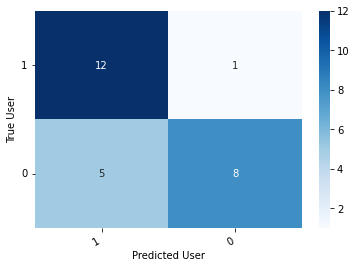

In [ ]:
# 3. running univariate: Rocket

import sys
from warnings import simplefilter
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor


simplefilter(action='ignore', category=FutureWarning)


seeds = [42, 1, 999, 4276, 67534]
n_samples = min(df_alt.rating.value_counts())

print("number of samples per class: ", n_samples)
print("\ntuning model...")
print("(data is shuffled)")

best_global_acc = 0
best_model = pd.DataFrame()

for seed in seeds:

  df_sample = df_alt.groupby('rating', group_keys=False).apply(lambda x: x.sample(n_samples, random_state=seed))
  # df_sample.participant_name.value_counts()

  y = df_sample['rating']
  X = df_sample
  del X['rating']

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

  print("\n_____________________________________________________________________")

  best_acc = 0
  best_df_eval = pd.DataFrame()
  print("total number of samples in X: ", len(X))

  for ix, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    print("\nfold: ", ix)
    print("\nlength a train data: ", len(train_index))
    print("\nlength a test data: ", len(test_index))
    X_train, X_test = X.take(train_index), X.take(test_index)
    y_train, y_test = y.take(train_index), y.take(test_index)

    # X_train = X_train.applymap(lambda s: pd.Series(s))
    # X_test = X_test.applymap(lambda s: pd.Series(s))

    # display(X_train)
    # print("\n0. xtrain", X_train.shape)
    # print("1. ytrain\n", y_train.shape)

    # print("training classifier...")
    minirocket = MiniRocket()  # MiniRocket() # for univariate; MiniRocketMultivariate; time series transformation
    minirocket.fit(X_train)
    X_train_transform = minirocket.transform(X_train)

    # print("\n2. xtrain-transform\n", X_train_transform.shape)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)

    classifier.fit(X_train_transform, y_train)

    X_test_transform = minirocket.transform(X_test)

    print("accuracy: ", classifier.score(X_test_transform, y_test))  # mean acc using LOO
    print("best_score_: ", classifier.best_score_)

    predictions = classifier.predict(X_test_transform)

    df_eval = pd.DataFrame([(p, t) for p, t in zip(predictions, y_test.tolist())], columns=["prediction", "truth"])

    if best_acc < classifier.score(X_test_transform, y_test):
      best_acc = classifier.score(X_test_transform, y_test)
      best_df_eval = df_eval

  print("\nbest acc: ", round(best_acc, 2))
  if best_acc > best_global_acc:
    best_global_acc = best_acc
    best_model = best_df_eval

print("\nbest global acc: ", round(best_global_acc, 2))
print(classification_report(best_model.truth.tolist(), best_model.prediction.tolist(), target_names=list(set(best_model.truth.tolist()))))

cm = confusion_matrix(best_model.truth.tolist(), best_model.prediction.tolist())
df_cm = pd.DataFrame(cm, index=list(set(best_model.truth.tolist())), columns=list(set(best_model.truth.tolist())))

show_confusion_matrix(df_cm)
plt.show()

In [ ]:
# 3. running univariate: Rocket
%%time
import sys
from warnings import simplefilter
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor


simplefilter(action='ignore', category=FutureWarning)


seeds = [42, 1, 999, 4276, 67534]
n_samples = min(df_alt.rating.value_counts())

print("number of samples per class: ", n_samples)
print("\ntuning model...")
print("(data is shuffled)")

best_global_acc = 0
best_model = pd.DataFrame()

for seed in seeds:

  df_sample = df_alt.groupby('rating', group_keys=False).apply(lambda x: x.sample(n_samples, random_state=seed))
  # df_sample.participant_name.value_counts()

  y = df_sample['rating']
  X = df_sample
  del X['rating']

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

  print("\n_____________________________________________________________________")

  best_acc = 0
  best_df_eval = pd.DataFrame()
  print("total number of samples in X: ", len(X))

  for ix, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    print("\nfold: ", ix)
    print("\nlength a train data: ", len(train_index))
    print("\nlength a test data: ", len(test_index))
    X_train, X_test = X.take(train_index), X.take(test_index)
    y_train, y_test = y.take(train_index), y.take(test_index)

    # X_train = X_train.applymap(lambda s: pd.Series(s))
    # X_test = X_test.applymap(lambda s: pd.Series(s))

    # display(X_train)
    # print("\n0. xtrain", X_train.shape)
    # print("1. ytrain\n", y_train.shape)

    # print("training classifier...")
    minirocket = MiniRocket()  # MiniRocket() # for univariate; MiniRocketMultivariate; time series transformation
    minirocket.fit(X_train)
    X_train_transform = minirocket.transform(X_train)

    # print("\n2. xtrain-transform\n", X_train_transform.shape)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)

    classifier.fit(X_train_transform, y_train)

    X_test_transform = minirocket.transform(X_test)

    print("accuracy: ", classifier.score(X_test_transform, y_test))  # mean acc using LOO
    print("best_score_: ", classifier.best_score_)

    predictions = classifier.predict(X_test_transform)

    df_eval = pd.DataFrame([(p, t) for p, t in zip(predictions, y_test.tolist())], columns=["prediction", "truth"])

    if best_acc < classifier.score(X_test_transform, y_test):
      best_acc = classifier.score(X_test_transform, y_test)
      best_df_eval = df_eval

  print("\nbest acc: ", round(best_acc, 2))
  if best_acc > best_global_acc:
    best_global_acc = best_acc
    best_model = best_df_eval

print("\nbest global acc: ", round(best_global_acc, 2))
#print(classification_report(best_model.truth.tolist(), best_model.prediction.tolist(), target_names=list(set(best_model.truth.tolist()))))

#cm = confusion_matrix(best_model.truth.tolist(), best_model.prediction.tolist())
#df_cm = pd.DataFrame(cm, index=list(set(best_model.truth.tolist())), columns=list(set(best_model.truth.tolist())))

#show_confusion_matrix(df_cm)
#plt.show()

number of samples per class:  64

tuning model...
(data is shuffled)

_____________________________________________________________________
total number of samples in X:  128

fold:  1

length a train data:  102

length a test data:  26
accuracy:  0.7307692307692307
best_score_:  -1.0470417069991382

fold:  2

length a train data:  102

length a test data:  26
accuracy:  0.34615384615384615
best_score_:  -0.9281124082760351

fold:  3

length a train data:  102

length a test data:  26
accuracy:  0.6153846153846154
best_score_:  -0.9850367596746676

fold:  4

length a train data:  103

length a test data:  25
accuracy:  0.48
best_score_:  -0.8975252715393953

fold:  5

length a train data:  103

length a test data:  25
accuracy:  0.6
best_score_:  -1.0175164868405782

best acc:  0.73

_____________________________________________________________________
total number of samples in X:  128

fold:  1

length a train data:  102

length a test data:  26
accuracy:  0.6923076923076923
best_sco

#### ROCKET Multivariate 

In [ ]:
df_alt

,pupil_dilation,relative_pupil_dilation,rating
4,0 -0.3565 1 -0.3565 2 -0.3464 3 ...,0 -0.3566 1 -0.3566 2 -0.3465 3 ...,1
6,0 -0.3151 1 0.3373 2 0.7393 3 ...,0 -0.3152 1 0.3373 2 0.7393 3 ...,0
10,0 0.0674 1 0.0674 2 -0.0219 3 ...,0 -0.2155 1 -0.2155 2 -0.4419 3 ...,0
13,0 -0.0811 1 -0.0811 2 -0.2045 3 ...,0 -0.0811 1 -0.0811 2 -0.2045 3 ...,0
18,0 0.6868 1 0.6820 2 0.6260 3 ...,0 0.6868 1 0.6819 2 0.6260 3 ...,0
...,...,...,...
462,0 -2.3485 1 -2.3439 2 -2.2964 3 ...,0 -2.3482 1 -2.3436 2 -2.2970 3 ...,0
465,0 -2.0049 1 -1.9824 2 -2.0558 3 ...,0 -2.0048 1 -1.9823 2 -2.0557 3 ...,1
466,0 -0.2462 1 -0.3986 2 -0.0733 3 ...,0 -0.2460 1 -0.3984 2 -0.0731 3 ...,1
468,0 -1.4679 1 -1.5208 2 -1.4300 3 ...,0 -1.4674 1 -1.5204 2 -1.4296 3 ...,0


number of samples per class:  64

tuning model...
(data is shuffled)

_____________________________________________________________________

fold:  1
accuracy:  0.6923076923076923

fold:  2
accuracy:  0.38461538461538464

fold:  3
accuracy:  0.6153846153846154

fold:  4
accuracy:  0.4

fold:  5
accuracy:  0.68

best acc:  0.69

_____________________________________________________________________

fold:  1
accuracy:  0.6538461538461539

fold:  2
accuracy:  0.3076923076923077

fold:  3
accuracy:  0.5

fold:  4
accuracy:  0.48

fold:  5
accuracy:  0.48

best acc:  0.65

_____________________________________________________________________

fold:  1
accuracy:  0.7307692307692307

fold:  2
accuracy:  0.23076923076923078

fold:  3
accuracy:  0.5769230769230769

fold:  4
accuracy:  0.52

fold:  5
accuracy:  0.56

best acc:  0.73

_____________________________________________________________________

fold:  1
accuracy:  0.6923076923076923

fold:  2
accuracy:  0.2692307692307692

fold:  3
accu

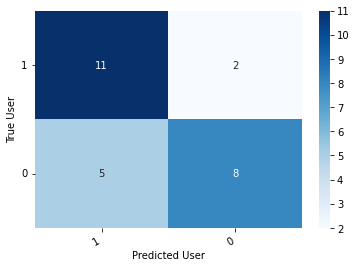

In [ ]:
# 3. running multivariate: Rocket

import sys
from warnings import simplefilter
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor


simplefilter(action='ignore', category=FutureWarning)


seeds = [42, 1, 999, 4276, 67534]
n_samples = min(df_alt.rating.value_counts())

print("number of samples per class: ", n_samples)
print("\ntuning model...")
print("(data is shuffled)")

best_global_acc = 0
best_model = pd.DataFrame()
scores = []

for seed in seeds:

  df_sample = df_alt.groupby('rating', group_keys=False).apply(lambda x: x.sample(n_samples, random_state=seed))
  # df_sample.participant_name.value_counts()

  y = df_sample['rating']
  X = df_sample
  del X['rating']

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

  print("\n_____________________________________________________________________")

  best_acc = 0
  best_df_eval = pd.DataFrame()

  for ix, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    print("\nfold: ", ix)
    X_train, X_test = X.take(train_index), X.take(test_index)
    y_train, y_test = y.take(train_index), y.take(test_index)

    # X_train = X_train.applymap(lambda s: pd.Series(s))
    # X_test = X_test.applymap(lambda s: pd.Series(s))

    # display(X_train)
    # print("\n0. xtrain", X_train.shape)
    # print("1. ytrain\n", y_train.shape)

    # print("training classifier...")
    minirocket = MiniRocketMultivariate()  # MiniRocket() # for univariate; MiniRocketMultivariate; time series transformation
    minirocket.fit(X_train)
    X_train_transform = minirocket.transform(X_train)

    # print("\n2. xtrain-transform\n", X_train_transform.shape)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)

    classifier.fit(X_train_transform, y_train)

    X_test_transform = minirocket.transform(X_test)

    print("accuracy: ", classifier.score(X_test_transform, y_test))

    predictions = classifier.predict(X_test_transform)

    df_eval = pd.DataFrame([(p, t) for p, t in zip(predictions, y_test.tolist())], columns=["prediction", "truth"])

    scores.append( classifier.score(X_test_transform, y_test))
    
    if best_acc < classifier.score(X_test_transform, y_test):
      best_acc = classifier.score(X_test_transform, y_test)
      best_df_eval = df_eval

  print("\nbest acc: ", round(best_acc, 2))
  if best_acc > best_global_acc:
    best_global_acc = best_acc
    best_model = best_df_eval

print("\nbest global acc: ", round(best_global_acc, 2))
print(classification_report(best_model.truth.tolist(), best_model.prediction.tolist(), target_names=list(set(best_model.truth.tolist()))))

cm = confusion_matrix(best_model.truth.tolist(), best_model.prediction.tolist())
df_cm = pd.DataFrame(cm, index=list(set(best_model.truth.tolist())), columns=list(set(best_model.truth.tolist())))

show_confusion_matrix(df_cm)
plt.show()

In [ ]:
print("number of compared models shuffling the data: ", len(scores))
print("mean score: ", np.mean(scores))

number of compared models shuffling the data:  25
mean score:  0.504676923076923


### TODO:

In [ ]:
# correlation matrix for the feature extraction as feasability study
# try more univariate models from already-in-use libraries
# add feature extraction with the real pupil dilation and fine tune an LSTM
# think in other models (ensemble...)
# add Tsaug data augmentation
# uploaded data to this notebook is already normalized. you might want to leave it raw and apply the same procedure, 
  # (in theory should be easy and you can duplicate the notebook not to loose the current output)

# if nothing works then report and clean notebook to template it.


-----------------------------------------------------------------------
# URGENT:
# average baseline; then substract real value to the baseline X
# create another version of the dataset with the extreme values, remove 2 and 3 scores.
# i am getting the best fold acc... I should be getting the average...